In [1]:
# General libraries
import sys
import warnings
# Numpy
import numpy as np
import numpy.linalg as lin
# Scipy
import scipy as sp
import scipy.linalg as splin
import scipy.sparse.linalg as slin
# Matplotlib
import matplotlib.pyplot as plt

# Utils

In [2]:
#############################################
# VCA algorithm
#############################################

def estimate_snr(Y,r_m,x):

  [L, N] = Y.shape           # L number of bands (channels), N number of pixels
  [p, N] = x.shape           # p number of endmembers (reduced dimension)
  
  P_y     = np.sum(Y**2)/float(N)
  P_x     = np.sum(x**2)/float(N) + np.sum(r_m**2)
  snr_est = 10*np.log10( (P_x - p/L*P_y)/(P_y - P_x) )

  return snr_est



def vca(Y,R,verbose = True,snr_input = 0):
    """ Vertex Component Analysis
    
     Ae, indice, Yp = vca(Y,R,verbose = True,snr_input = 0)
    
     ------- Input variables -------------
      Y - matrix with dimensions L(channels) x N(pixels)
          each pixel is a linear mixture of R endmembers
          signatures Y = M x s, where s = gamma x alfa
          gamma is a illumination perturbation factor and
          alfa are the abundance fractions of each endmember.
      R - positive integer number of endmembers in the scene
    
     ------- Output variables -----------
     Ae     - estimated mixing matrix (endmembers signatures)
     indice - pixels that were chosen to be the most pure
     Yp     - Data matrix Y projected.   
    
     ------- Optional parameters---------
     snr_input - (float) signal to noise ratio (dB)
     v         - [True | False]
     ------------------------------------
    
     Author: Adrien Lagrange (adrien.lagrange@enseeiht.fr)
     This code is a translation of a matlab code provided by 
     Jose Nascimento (zen@isel.pt) and Jose Bioucas Dias (bioucas@lx.it.pt)
     available at http://www.lx.it.pt/~bioucas/code.htm under a non-specified Copyright (c)
     Translation of last version at 22-February-2018 (Matlab version 2.1 (7-May-2004))
    
     more details on:
     Jose M. P. Nascimento and Jose M. B. Dias 
     "Vertex Component Analysis: A Fast Algorithm to Unmix Hyperspectral Data"
     submited to IEEE Trans. Geosci. Remote Sensing, vol. .., no. .., pp. .-., 2004
    """ 
 

    #############################################
    # Initializations
    #############################################
    if len(Y.shape)!=2:
        sys.exit('Input data must be of size L (number of bands i.e. channels) by N (number of pixels)')

    [L, N]=Y.shape   # L number of bands (channels), N number of pixels
       
    if (R<0 or R>L):  
        sys.exit('ENDMEMBER parameter must be integer between 1 and L')
        
    #############################################
    # SNR Estimates
    #############################################

    if snr_input==0:
        y_m = np.mean(Y,axis=1,keepdims=True)
        Y_o = Y - y_m           # data with zero-mean
        Ud  = splin.svd(np.dot(Y_o,Y_o.T)/float(N))[0][:,:R]  # computes the R-projection matrix 
        x_p = np.dot(Ud.T, Y_o)                 # project the zero-mean data onto p-subspace

        SNR = estimate_snr(Y,y_m,x_p);
    
        if verbose:
            print("SNR estimated = {}[dB]".format(SNR))
    else:
        SNR = snr_input
        if verbose:
            print("input SNR = {}[dB]\n".format(SNR))

    SNR_th = 15 + 10*np.log10(R)
         
    #############################################
    # Choosing Projective Projection or 
    #          projection to p-1 subspace
    #############################################

    if SNR < SNR_th:
        if verbose:
            print("... Select the projective proj.")
                
        d = R-1
        if snr_input==0: # it means that the projection is already computed
            Ud = Ud[:,:d]
        else:
            y_m = np.mean(Y,axis=1,keepdims=True)
            Y_o = Y - y_m  # data with zero-mean 
         
            Ud  = splin.svd(np.dot(Y_o,Y_o.T)/float(N))[0][:,:d]  # computes the p-projection matrix 
            x_p =  np.dot(Ud.T,Y_o)                 # project thezeros mean data onto p-subspace
                
        Yp =  np.dot(Ud,x_p[:d,:]) + y_m      # again in dimension L
                
        x = x_p[:d,:] #  x_p =  Ud.T * Y_o is on a R-dim subspace
        c = np.amax(np.sum(x**2,axis=0))**0.5
        y = np.vstack(( x, c*np.ones((1,N)) ))
    else:
        if verbose:
            print("... Select proj. to R-1")
             
        d = R
        Ud  = splin.svd(np.dot(Y_o,Y_o.T)/float(N))[0][:,:d] # computes the p-projection matrix 
                
        x_p = np.dot(Ud.T,Y)
        Yp =  np.dot(Ud,x_p[:d,:])      # again in dimension L (note that x_p has no null mean)
                
        x =  np.dot(Ud.T,Y)
        u = np.mean(x,axis=1,keepdims=True)        #equivalent to  u = Ud.T * r_m
        y =  x / sum( x * u)

 
    #############################################
    # VCA algorithm
    #############################################

    indice = np.zeros((R),dtype=int)
    A = np.zeros((R,R))
    A[-1,0] = 1

    for i in range(R):
        w = np.random.rand(R,1);   
        f = w - np.dot(A,np.dot(splin.pinv(A),w))
        f = f / np.sqrt(sum(f**2))
      
        v = np.dot(f.T,y)

        indice[i] = np.argmax(np.absolute(v))
        A[:,i] = y[:,indice[i]]        # same as x(:,indice(i))

    Ae = Yp[:,indice]

    return (Ae,indice,Yp)




#############################################
# SUNSAL algorithm
#############################################

def sunsal(M,y,**kwargs):
    """
    x = sunsal_v2(M,Y,**kwargs)
        
    ----- Description ---------------
        
    SUNSAL (sparse unmixing via variable splitting and augmented Lagrangian 
    methods) algorithm implementation. Accepted constraints are:
        1. Positivity:  X >= 0
        2. Addone:      np.sum(X,axis=0) = np.ones(N)
    
    For details see
    
    [1] J. Bioucas-Dias and M. Figueiredo, “Alternating direction algorithms
    for constrained sparse regression: Application to hyperspectral unmixing”,
    in 2nd  IEEE GRSS Workshop on Hyperspectral Image and Signal
    Processing-WHISPERS'2010, Raykjavik, Iceland, 2010.
    
    
    ----- Input ---------------------
    
    M - endmember signature matrix with dimensions L(channels) x p(endmembers)
    
    Y - matrix with dimensions L(channels) x N(pixels). Each pixel
        is a linear mixture of p endmembers signatures
    
    ----- Optional input ------------
    
    al_iters - Minimum number of augmented Lagrangian iterations
               Default: 100
    
    lambda_p - regularization parameter. lambda is either a scalar
               or a vector with N components (one per column of x)
               Default: 0
    
    
    positivity - {True, False} Enforces the positivity constraint
                 Default: False
    
    addone - {True, False} Enforces the addone constraint
             Default: False
    
    tol - tolerance for the primal and  dual residuals
          Default: 1e-4
    
    
    verbose = {True, False}
              False - work silently
              True - display iteration info
              Default: True
    
    ----- Output --------------------
    
    X - estimated abundance matrix of size p x N
    
    ----- License -------------------
    Author: Etienne Monier (etienne.monier@enseeiht.fr)
    
    This code is a translation of a matlab code provided by 
    Jose Nascimento (zen@isel.pt) and Jose Bioucas Dias (bioucas@lx.it.pt)
    available at http://www.lx.it.pt/~bioucas/code.htm under a non-specified Copyright (c)
    Translation of last version at 20-April-2018 (Matlab version 2.1 (7-May-2004))
       
    """
    
    
    #--------------------------------------------------------------
    # test for number of required parametres
    #--------------------------------------------------------------
    
    # mixing matrixsize
    LM,p = M.shape
    # data set size
    L,N = y.shape
    if (LM != L):
        raise ValueError('mixing matrix M and data set y are inconsistent')
    
    
    #--------------------------------------------------------------
    # Set the defaults for the optional parameters
    #--------------------------------------------------------------
    
    # maximum number of AL iteration
    AL_iters = 1000
    # regularizatio parameter
    Lambda = 0.0
    # display only sunsal warnings
    verbose = True
    # Positivity constraint
    positivity = False
    # Sum-to-one constraint
    addone = False
    # tolerance for the primal and dual residues
    tol = 1e-4;
    # initialization
    x0 = 0;
    
    
    #--------------------------------------------------------------
    # Local variables
    #--------------------------------------------------------------
    #--------------------------------------------------------------
    # Read the optional parameters
    #--------------------------------------------------------------
    
    
    for key in kwargs:
        Ukey = key.upper()
        
        if(Ukey == 'AL_ITERS'):
            AL_iters = np.round(kwargs[key]);
            if (AL_iters < 0 ):
                raise ValueError('AL_iters must a positive integer');
        elif(Ukey == 'LAMBDA_P'):
            Lambda = kwargs[key]
            if (np.sum(np.sum(Lambda < 0)) >  0 ):
                raise ValueError('lambda_p must be positive');
        elif (Ukey =='POSITIVITY'):
            positivity =  kwargs[key]
        elif (Ukey=='ADDONE'):
            addone = kwargs[key]
        elif(Ukey=='TOL'):
            tol = kwargs[key]
        elif(Ukey=='VERBOSE'):
            verbose = kwargs[key]
        elif(Ukey=='X0'):
            x0 = kwargs[key]
            if (x0.shape[0] != p) | (x0.shape[1] != N):
                raise ValueError('initial X is  inconsistent with M or Y');
        elif(Ukey=='X_SOL'):
            X_sol = kwargs[key]
        elif(Ukey=='CONV_THRE'):
            conv_thre = kwargs[key]
        else:
            # Hmmm, something wrong with the parameter string
            raise ValueError('Unrecognized option: {}'.format(key))


    #---------------------------------------------
    #  If lambda is scalar convert it into vector
    #---------------------------------------------
    Nlambda = np.array(Lambda).size
    if (Nlambda == 1):
        # same lambda for all pixels
        Lambda = Lambda*np.ones((p,N));
    elif (Nlambda != N):
        raise ValueError('Lambda size is inconsistent with the size of the data set');
    else :
        # each pixel has its own lambda
        Lambda = np.repeat(Lambda[np.newaxis,:],p,axis=0)
    
    
    # compute mean norm
    norm_m = np.sqrt(np.mean(M**2))*(25+p)/p
    # rescale M and Y and lambda
    M = M/norm_m;
    y = y/norm_m;
    Lambda = Lambda/norm_m**2
    
    
    ##
    #---------------------------------------------
    # just least squares
    #---------------------------------------------
    if np.sum(Lambda == 0) and not addone and not positivity :
        z = lin.pinv(M).dot(y)
        # primal and dual residues
        res_p = 0
        res_d = 0
        i = 0
        return (z,res_p,res_d,i)
    
    #---------------------------------------------
    # least squares constrained (sum(x) = 1)
    #---------------------------------------------
    SMALL = 1e-12
    B = np.ones((1,p))
    a = np.ones((1,N))
    if np.sum(Lambda == 0) and addone and not positivity :
        F = np.transpose(M).dot(M)
        # test if F is invertible
        if lin.cond(F) > SMALL :
            # compute the solution explicitly
            IF = lin.inv(F)
            z = IF.dot(M.T).dot(y)-IF.dot(B.T).dot(lin.inv(B.dot(IF).dot(B.T))).dot(B.dot(IF).dot(M.T).dot(y)-a)
            # primal and dual residues
            res_p = 0
            res_d = 0
            i = 0
            return (z,res_p,res_d,i)
    
    
    ##
    #---------------------------------------------
    #  Constants and initializations
    #---------------------------------------------
    mu_AL = 0.01
    mu = 10*np.mean(Lambda) + mu_AL
    
    UF,sF,VF = lin.svd(M.T.dot(M))
    SF = np.diag(sF)
    IF = UF.dot(np.diag(1/(sF+mu))).dot(UF.T)
    
    Aux = IF.dot(B.T).dot(lin.inv(B.dot(IF).dot(B.T)))
    x_aux = Aux.dot(a)
    IF1 = IF-Aux.dot(B).dot(IF)
    yy = M.T.dot(y)
    
    ##
    #---------------------------------------------
    #  Initializations
    #---------------------------------------------
    # no intial solution supplied
    if x0 == 0:
       x = IF.dot(M.T).dot(y)
    else:
        x = x0
    
    z = x
    # scaled Lagrange Multipliers
    d  = 0*z
    
    #
    #---------------------------------------------
    #  AL iterations - main body
    #---------------------------------------------
    
    tol1 = np.sqrt(N*p)*tol
    tol2 = np.sqrt(N*p)*tol
    i=1
    res_p = float("inf")
    res_d = float("inf")
    maskz = np.ones(z.shape)
    mu_changed = 0
    
    z_err_set=np.ones((1,10))*1e10
    
    #--------------------------------------------------------------------------
    # constrained  leat squares (CLS) X >= 0
    #--------------------------------------------------------------------------
    
    if np.sum(Lambda ==  0)  and not addone:
        while (i <= AL_iters) and ((np.abs(res_p) > tol1) or (np.abs(res_d) > tol2)):
            # save z to be used later
            if i%10 == 1 :
                z0 = z
            
            # minimize with respect to z
            z = np.maximum(x-d,0)
            # minimize with respect to x
            x = IF.dot(yy+mu*(z+d))
            # Lagrange multipliers update
            d = d -(x-z)
            
            # update mu so to keep primal and dual residuals whithin a factor of 10
            if i%10 == 1 :
                # primal residue
                res_p = lin.norm(x-z)
                # dual residue
                res_d = mu*lin.norm(z-z0)
                if verbose:
                    print(' i = {}, res_p = {}, res_d = {}\n'.format(i,res_p,res_d))
    
                # update mu
                if res_p > 10*res_d :
                    mu = mu*2
                    d = d/2
                    mu_changed = 1
                elif res_d > 10*res_p :
                    mu = mu/2
                    d = d*2
                    mu_changed = 1
                
                if  mu_changed :
                    # update IF and IF1
                    
                    IF = UF.dot(np.diag(1/(sF+mu))).dot(UF.T)
                    Aux = IF.dot(B.T).dot(lin.inv(B.dot(IF).dot(B.T)))
                    x_aux = Aux.dot(a)
                    IF1 = IF-Aux.dot(B).dot(IF)
                    mu_changed = 0
        
            i=i+1;
        
    #--------------------------------------------------------------------------
    # Fully constrained  leat squares (FCLS) X >= 0
    #--------------------------------------------------------------------------
    elif np.sum(Lambda ==  0)  and addone:
        while (i <= AL_iters) and ((np.abs(res_p) > tol1) or (np.abs(res_d) > tol2))  :
            # save z to be used later
            if i%10 == 1 :
                z0 = z
            
            # minimize with respect to z
            z = np.maximum(x-d,0)
            # minimize with respect to x
            x = IF1.dot(yy+mu*(z+d))+x_aux
            # Lagrange multipliers update
            d = d -(x-z)
            
            # update mu so to keep primal and dual residuals whithin a factor of 10
            if i%10 == 1:
                # primal residue
                res_p = lin.norm(x-z)
                # dual residue
                res_d = mu*lin.norm(z-z0)
                if verbose:
                    print(' i = {}, res_p = {}, res_d = {}\n'.format(i,res_p,res_d))
    
                # update mu
                if res_p > 10*res_d :
                    mu = mu*2
                    d = d/2
                    mu_changed = 1
                elif res_d > 10*res_p :
                    mu = mu/2
                    d = d*2
                    mu_changed = 1
                
                if  mu_changed:
                    # update IF and IF1
                    
                    IF = UF.dot(np.diag(1./(sF+mu))).dot(UF.T)
                    Aux = IF.dot(B.T).dot(lin.inv(B.dot(IF).dot(B.T)))
                    x_aux = Aux.dot(a)
                    IF1 = IF-Aux.dot(B).dot(IF)
                    mu_changed = 0
                    
            
            i=i+1;
    
    #--------------------------------------------------------------------------
    # generic SUNSAL: lambda > 0
    #--------------------------------------------------------------------------
    
    else :
        softthresh = lambda x,th : np.sign(x)*np.maximum(np.abs(x)-th,0)
        
        # implement soft_th
        while (i <= AL_iters) and ((np.abs(res_p) > tol1) or (np.abs(res_d) > tol2)) : 
            # save z to be used later
            if i%10 == 1:
                z0 = z
            
            # minimize with respect to z
            z =  softthresh(x-d,Lambda/mu)
            # test for positivity
            if positivity :
                z = np.max(z,0)
            
            # test for sum-to-one
            if addone :
                x = IF1.dot(yy+mu*(z+d))+x_aux
            else:
                x = IF.dot(yy+mu*(z+d))
            
            # Lagrange multipliers update
            d = d -(x-z)
            
            # update mu so to keep primal and dual residuals whithin a factor of 10
            if i%10 == 1 :
                # primal residue
                res_p = lin.norm(x-z)
                # dual residue
                res_d = mu*lin.norm(z-z0)
                if verbose:
                    print(' i = {}, res_p = {}, res_d = {}\n'.format(i,res_p,res_d))
                
                # update mu
                if res_p > 10*res_d :
                    mu = mu*2
                    d = d/2
                    mu_changed = 1
                elif res_d > 10*res_p :
                    mu = mu/2
                    d = d*2
                    mu_changed = 1
                    
                if mu_changed:
                    # update IF and IF1
                    
                    IF = UF.dot(np.diag(1./(sF+mu))).dot(UF.T)
                    Aux = IF.dot(B.T).dot(lin.inv(B.dot(IF).dot(B.T)))
                    x_aux = Aux.dot(a)
                    IF1 = IF-Aux.dot(B).dot(IF)
                    mu_changed = 0
                            
            i=i+1
            
    #########################################################################
    
    return (x,res_p,res_d,i)


#############################################
# SISAL algorithm
#############################################

def soft_neg(y,tau) :
    """  z = soft_neg(y,tau);
    
      negative soft (proximal operator of the hinge function)
    """

    z = np.maximum(np.abs(y+tau/2) - tau/2, 0)
    z = z*(y+tau/2)/(z+tau/2)
    return z

def sisal(Y,p,**kwargs):
    """
    M,Up,my,sing_values = sisal(Y,p,**kwargs)
        
    ----- Description ---------------
        
    Simplex identification via split augmented Lagrangian (SISAL) estimates 
    the vertices  M={m_1,...m_p} of the (p-1)-dimensional simplex of minimum 
    volume containing the vectors [y_1,...y_N], under the assumption that y_i
    belongs to a (p-1)  dimensional affine set.
    
    For details see
    
    [1] José M. Bioucas-Dias, "A variable splitting augmented lagrangian
    approach to linear spectral unmixing", First IEEE GRSS Workshop on 
    Hyperspectral Image and Signal Processing - WHISPERS, 2009. 
    http://arxiv.org/abs/0904.4635v1
    
    
    ----- Input ---------------------
    
    Y - matrix with dimension  L(channels) x N(pixels). Each pixel is a linear
        mixture of p endmembers signatures Y = M*x + noise.
    
    p - number of independent columns of M. Therefore, M spans a (p-1)-dimensional
        affine set. p is the number of endmembers.
    
    ----- Optional input ------------
    
    
    mm_iters - Maximum number of constrained quadratic programs
               Default: 80
    
    tau - Regularization parameter in the problem
             Q^* = arg min_Q  -\log abs(det(Q)) + tau*|| Q*yp ||_h
                   subject to np.ones((1,p))*Q=mq
             where mq = ones(1,N)*yp'inv(yp*yp) and ||x||_h is the "hinge"
             induced norm (see [1]).
          Default: 1
    
    mu - Augmented Lagrange regularization parameter
         Default: 1
    
    spherize - {True, False} Applies a spherization step to data such that the spherized
               data spans over the same range along any axis.
               Default: True
    
    tolf - Tolerance for the termination test (relative variation of f(Q))
           Default: 1e-2
    
    M0 - Initial M, dimension L x p. 
         Defaults is given by the VCA algorithm.
    
    verbose - {0,1,2,3} 
                    0 - work silently
                    1 - display simplex volume
                    2 - display figures
                    3 - display SISAL information 
                    4 - display SISAL information and figures
              Default: 1
    
    ----- Output --------------------
    
    M - estimated endmember signature matrix L(channels) x p(endmembers)
    
    Up - isometric matrix spanning the same subspace as M, imension is L x p
    
    my - mean value of Y
    
    sing_values - (p-1) eigenvalues of Cy = (y-my)*(y-my)/N. The dynamic range
                  of these eigenvalues gives an idea of the  difficulty of the
                  underlying problem
    
    ----- Note ----------------------
    
    The identified affine set is given by
           {z\in R^p : z=Up(:,1:p-1)*a+my, a\in R^(p-1)}
    
    
    ----- License -------------------
    Author: Etienne Monier (etienne.monier@enseeiht.fr)
    
    This code is a translation of a matlab code provided by 
    Jose Nascimento (zen@isel.pt) and Jose Bioucas Dias (bioucas@lx.it.pt)
    available at http://www.lx.it.pt/~bioucas/code.htm under a non-specified Copyright (c)
    Translation of last version at 20-April-2018 (Matlab version 2.1 (7-May-2004))
       
    """
    
    #
    # -------------------------------------------------------------------------
    #
    #
    #--------------------------------------------------------------
    # test for number of required parametres
    #--------------------------------------------------------------
    
    # data set size
    L,N = Y.shape
    if (L<p) :
        raise ValueError('Insufficient number of columns in y')
    
    ##
    #--------------------------------------------------------------
    # Set the defaults for the optional parameters
    #--------------------------------------------------------------
    # maximum number of quadratic QPs
    
    MMiters = 80
    spherize = True
    # display only volume evolution
    verbose = 1
    # soft constraint regularization parameter
    tau = 1
    # Augmented Lagrangian regularization parameter
    mu = p*1000/N
    # no initial simplex
    M = 0
    # tolerance for the termination test
    tol_f = 1e-2
    
    ##
    #--------------------------------------------------------------
    # Local variables
    #--------------------------------------------------------------
    # maximum violation of inequalities
    slack = 1e-3
    # flag energy decreasing
    energy_decreasing = 0
    # used in the termination test
    f_val_back = float("inf")
    #
    # spherization regularization parameter
    lam_sphe = 1e-8
    # quadractic regularization parameter for the Hesssian
    # Hreg = = mu*I
    lam_quad = 1e-6
    # minimum number of AL iterations per quadratic problem 
    AL_iters = 4
    # flag 
    flaged = 0
    
    #--------------------------------------------------------------
    # Read the optional parameters
    #--------------------------------------------------------------
    
    for key in kwargs:
        Ukey = key.upper()
        
        if(Ukey == 'MM_ITERS'):
            MMiters = kwargs[key]
        elif(Ukey == 'SPHERIZE'):
            spherize = kwargs[key]
        elif (Ukey =='MU'):
            mu =  kwargs[key]
        elif (Ukey=='TAU'):
            tau = kwargs[key]
        elif(Ukey=='TOLF'):
            tol_f = kwargs[key]
        elif(Ukey=='M0'):
            M = kwargs[key]
        elif(Ukey=='VERBOSE'):
            verbose = kwargs[key]
        else:
            # Hmmm, something wrong with the parameter string
            raise ValueError('Unrecognized option: {}'.format(key))
    
    
    ##
    #--------------------------------------------------------------
    # set display mode
    #--------------------------------------------------------------
    if (verbose == 3) or (verbose == 4):
        warnings.filterwarnings("ignore")
    else :
        warnings.filterwarnings("always")
    
    
    ##
    #--------------------------------------------------------------
    # identify the affine space that best represent the data set y
    #--------------------------------------------------------------
    my = np.mean(Y,axis=1)
    My = np.repeat(my[:,np.newaxis],N,axis=1)
    Myp = np.repeat(my[:,np.newaxis],p,axis=1)
    
    Y = Y-My
    Up,d,_ = lin.svd(Y@Y.T/N)
    sort_ind = np.argsort(d)[::-1]
    Up = Up[:,sort_ind[:p-1]]
    d = d[sort_ind[:p-1]]
    
    # represent y in the subspace R^(p-1)
    Y = Up@Up.T@Y
    # lift y
    Y = Y + My
    # compute the orthogonal component of my
    my_ortho = my-Up@Up.T.dot(my)
    # define another orthonormal direction
    Up = np.concatenate((Up, (my_ortho/np.sqrt(np.sum(my_ortho**2)))[:,np.newaxis] ),axis=1)
    sing_values = d
    
    # get coordinates in R^p
    Y = Up.T@Y
    
    
    ##
    #------------------------------------------
    # spherize if requested
    #------------------------------------------
    if spherize:
        Y = Up@Y
        Y = Y-My
        C = np.diag(1/np.sqrt(d+lam_sphe))
        IC = lin.inv(C)
        Y=C.dot(np.transpose(Up[:,:p-1])).dot(Y)
        # lift
        Y = np.concatenate((Y,np.ones((1,N))),axis=0)
        #Y[p-1,:] = 1
        # normalize to unit norm
        Y = Y/np.sqrt(p)
    
    
    ##
    # ---------------------------------------------
    #            Initialization
    #---------------------------------------------
    if M == 0:
        # Initialize with VCA
        Mvca,_,_ = vca(Y,p,verbose=False)
        M = Mvca
        # expand Q
        Ym = np.mean(M,axis=1)
        Ym = np.repeat(Ym[:,np.newaxis],p,axis=1)
        dQ = M - Ym 
        # fraction: multiply by p is to make sure Q0 starts with a feasible
        # initial value.
        M = M + p*dQ
    else:
        # Ensure that M is in the affine set defined by the data
        M = M-Myp
        M = Up[:,:p-1]@Up[:,:p-1].T@M
        M = M + Myp
        M = Up.T@M   # represent in the data subspace
        # is sherization is set
        if spherize:
            M = Up@M-Myp
            M=C@Up[:,:p-1].T@M
            # lift
            M[p-1,:] = 1
            # normalize to unit norm
            M = M/np.sqrt(p)
    
    
    Q0 = lin.inv(M)
    Q=Q0
    
    
    # plot  initial matrix M
    if verbose == 2 or verbose == 4 :
        
        M = lin.inv(Q)
        fig,ax = plt.subplots()
        
        line1 = ax.plot(Y[0,:],Y[1,:],'.')
        line2 = ax.plot(M[0,:], M[1,:],'ok')
    
        ax.set_title('SISAL: Endmember Evolution')
        
    
    #
    # ---------------------------------------------
    #            Build constant matrices
    #---------------------------------------------
    
    AAT = np.kron(Y@Y.T,np.eye(p))     # size p^2xp^2
    B = np.kron(np.eye(p),np.ones((1,p)))   # size pxp^2
    qm = np.sum(lin.inv(Y@Y.T)@Y,axis=1)
    
    H = lam_quad*np.eye(p**2)
    F = H+mu*AAT              # equation (11) of [1]
    IF = lin.inv(F)
    
    # auxiliar constant matrices
    G = IF@B.T@lin.inv(B@IF@B.T)
    qm_aux = G.dot(qm)
    G = IF-G@B@IF
    
    
    ##
    # ---------------------------------------------------------------
    #          Main body- sequence of quadratic-hinge subproblems
    #----------------------------------------------------------------
    
    # initializations
    Z = Q@Y
    Bk = 0*Z
    
    hinge = lambda x: np.maximum(-x,0)
    
    
    for k in range(MMiters):
        
        IQ = lin.inv(Q)
        g = -IQ.T
        g = g.flatten(order='C')
    
        baux = H@Q.flatten(order='C')-g
    
        q0 = Q.flatten(order='C')
        Q0 = Q
        
        # display the simplex volume
        if verbose == 1 :
            if spherize:
                # unscale
                M = IQ*np.sqrt(p)
                # remove offset
                M = M[:p-1,:]
                # unspherize
                M = Up[:,:p-1].dot(IC).dot(M)
                # sum ym
                M = M + Myp
                M = Up.T.dot(M)
            else:
                M = IQ
            
            print('\n iter = {0}, simplex volume = {1:.4e}  \n'.format(k, 1/np.abs(lin.det(M))))
    
        
        if k == MMiters :
            AL_iters = 100
                
        
        while 1 :
            q = Q.flatten(order='C')
            # initial function values (true and quadratic)
            f0_val = -np.log(np.abs(lin.det(Q)))+ tau*np.sum(hinge(Q@Y))
            f0_quad = (q-q0).T.dot(g)+0.5*(q-q0).T.dot(H).dot(q-q0) + tau*np.sum(hinge(Q.dot(Y)))
            for i in range(AL_iters-1):
                #-------------------------------------------
                # solve quadratic problem with constraints
                #-------------------------------------------
                dq_aux= Z+Bk                # matrix form
                dtz_b = dq_aux@Y.T
                dtz_b = dtz_b.flatten(order='C')
                b = baux+mu*dtz_b           # (11) of [1]
                q = G.dot(b)+qm_aux         # (10) of [1]
                Q = np.reshape(q,(p,p),order='C')
                
                #-------------------------------------------
                # solve hinge
                #-------------------------------------------
                Z = soft_neg(Q@Y-Bk,tau/mu);
                
                #-------------------------------------------
                # update Bk
                #-------------------------------------------
                
                Bk = Bk - (Q@Y-Z)
                if verbose == 3 or  verbose == 4 :
                    print('\n ||Q*Y-Z|| = {0:.4f}'.format(lin.norm(Q.dot(Y)-Z)))
                
                if verbose == 2 or verbose == 4:
                    M = lin.inv(Q)
                    line2.set_xdata(M[0,:])
                    line2.set_ydata(M[1,:])
                    plt.draw()
                    if ~flaged :
                         line3 = ax.plot(M[0,:], M[1,:],'.r')
                         legend( 'data points','M(0)','M(k)')
                         flaged = 1
            
            
            f_quad = (q-q0).T.dot(g)+0.5*(q-q0).T.dot(H).dot(q-q0) + tau*np.sum(hinge(Q@Y))
            if verbose == 3 or  verbose == 4:
                print('\n MMiter = {0}, AL_iter, = {1},  f0 = {2:2.4f}, f_quad = {3:2.4f},  \n'.format(k,i, f0_quad,f_quad))
    
            f_val = -np.log(np.abs(lin.det(Q)))+ tau*np.sum(hinge(Q.dot(Y)))
            if f0_quad >= f_quad:            # quadratic energy decreased
                try:
                    while  f0_val < f_val :
                        if verbose == 3 or  verbose == 4 :
                            print('\n line search, MMiter = {0}, AL_iter, = {1},  f0 = {2:2.4f}, f_val = {3:2.4f},  \n'.format(k,i, f0_val,f_val))
    
                    # do line search
                        Q = (Q+Q0)/2
                        f_val = -np.log(np.abs(lin.det(Q)))+ tau*sum(hinge(Q@Y))
                    break
                except:
                    1+1
    
    
    if verbose == 2 or verbose == 4:
        
        ax.legend('data points','M(0)',  'M(final)')
        
#        p_H(4) = plot(M(1,:), M(2,:),'*g');
#        leg_cell{end+1} = ;
#        legend(p_H', leg_cell);
#    end
    
    
    if spherize :
        M = lin.inv(Q)
        # refer to the initial affine set
        # unscale
        M = M*np.sqrt(p)
        # remove offset
        M = M[:p-1,:]
        # unspherize
        M = Up[:,:p-1].dot(IC).dot(M)
        # sum ym
        M = M + Myp
    else :
        M = Up.dot(lin.inv(Q))
    
    
    return (M,Up,my,sing_values)


#####################################################################################



# Run

In [3]:
# M - estimated endmember signature matrix L x p
# Up - isometric matrix spanning the same subspace as M, dimension is L x p
# my - mean value of Y
    
# sing_values - (p-1) eigenvalues of Cy = (y-my)*(y-my)/N. The dynamic range
#                   of these eigenvalues gives an idea of the  difficulty of the
#                   underlying problem
# mm_iters - Maximum number of constrained quadratic programs
#                Default: 80
    
# tau - Regularization parameter in the problem
#              Q^* = arg min_Q  -\log abs(det(Q)) + tau*|| Q*yp ||_h
#                    subject to np.ones((1,p))*Q=mq
#              where mq = ones(1,N)*yp'inv(yp*yp) and ||x||_h is the "hinge"
#              induced norm (see [1]).
#           Default: 1
    
# mu - Augmented Lagrange regularization parameter
#          Default: 1
    
# spherize - {True, False} Applies a spherization step to data such that the spherized
#                data spans over the same range along any axis.
#                Default: True
    
# tolf - Tolerance for the termination test (relative variation of f(Q))
#            Default: 1e-2
    
# M0 - Initial M, dimension L x p. 
#          Defaults is given by the VCA algorithm.

In [7]:
def generate_data(n_samples=1):
    x = np.random.exponential(scale=1.0, size=(n_samples, 20))
    return x / np.sum(x, axis=1, keepdims=True)

Y = sample_from_2simplex(100).T

M, Up, my, sing_values = sisal(Y, 3, verbose=False, mu=1, tau=0)

/var/folders/b3/3vgsg15j72gc54f0qpjcfkym0000gn/T/ipykernel_97736/1482402850.py:12: RuntimeWarning: invalid value encountered in log10
  snr_est = 10*np.log10( (P_x - p/L*P_y)/(P_y - P_x) )


In [13]:
Y.shape, M.shape, Up.shape

((20, 100), (20, 3), (20, 3))

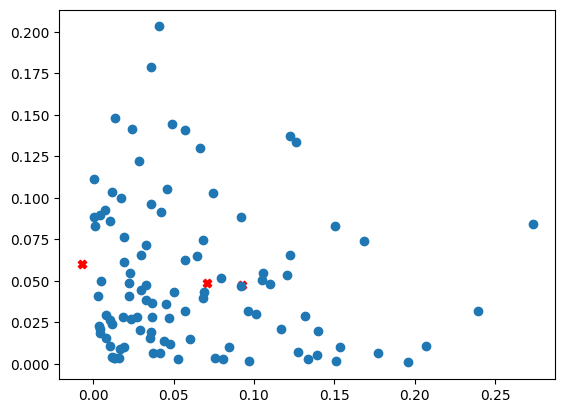

In [17]:
plt.plot(Y[0,:], Y[1,:], 'o', label='Original Data')
for m in M.T: 
    plt.scatter(
        m[0],
        m[1],
        marker='X',
        color='red'
    )

In [ ]:
sing_values